In [12]:
import json

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import shap

from sklearn.metrics import r2_score, mean_squared_error

In [2]:
features_dir = Path("data") / "features"

X_train = pd.read_csv(features_dir / "X_train.csv")
X_test = pd.read_csv(features_dir / "X_test.csv")
y_train = pd.read_csv(features_dir / "y_train.csv")
y_test = pd.read_csv(features_dir / "y_test.csv")

with open(features_dir / "meta.json", "r") as f:
    meta = json.load(f)

categorical_features = meta["categorical_features"]

In [3]:
X_train.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,420673373,0.958782,1.00,1.00,0,0,52.29860,4.95581,2,1.0,...,0,0,0,0,0,0,0,0,0,0
1,429206111,0.970761,0.91,1.00,0,0,52.36525,4.87946,4,1.0,...,0,0,0,0,0,0,0,1,1,0
2,293464674,0.812589,1.00,1.00,1,1,51.92125,4.49959,2,1.0,...,0,1,1,0,0,0,0,2,2,1
3,80550302,0.575431,0.75,0.90,1,1,51.91032,4.52203,1,1.0,...,0,1,0,0,1,0,0,3,3,1
4,237371423,0.765076,0.92,0.99,8,8,52.38586,4.87644,2,1.0,...,0,1,0,0,0,0,0,4,4,1


In [4]:
X_test.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,25677161,0.465990,1.0,0.88,1,1,52.375460,4.876560,4,2.0,...,0,1,1,0,1,1,1,4.0,3.0,1
1,5923086,0.337665,1.0,0.71,2,2,51.924070,4.491460,1,1.0,...,0,1,1,0,1,1,0,29.0,18.0,1
2,5878526,0.337056,1.0,0.57,1,1,52.360640,4.976430,4,1.0,...,0,1,1,0,1,1,0,41.0,10.0,0
3,837675,0.208731,1.0,1.00,1,1,52.382830,4.967150,4,2.0,...,0,1,1,0,1,1,0,6.0,27.0,0
4,32424525,0.489543,0.8,1.00,1,1,52.385609,4.878721,4,3.0,...,0,1,1,0,1,1,0,4.0,0.0,0


In [5]:
categorical_features

['host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'city',
 'has_license',
 'is_bathroom_private',
 'host_verifications_phone',
 'host_verifications_email',
 'host_verifications_jumio',
 'host_verifications_reviews',
 'host_verifications_government_id',
 'amenities_Wifi',
 'amenities_Essentials',
 'amenities_Smoke alarm',
 'amenities_Heating',
 'amenities_Hangers',
 'amenities_Long term stays allowed',
 'amenities_Kitchen',
 'amenities_Hair dryer',
 'amenities_Hot water',
 'amenities_Iron',
 'host_id']

In [6]:
y_train

,price
0,159.0
1,357.0
2,85.0
3,46.0
4,103.0
...,...
5723,94.0
5724,60.0
5725,180.0
5726,145.0


In [7]:
y_test.head()

,price
0,225.0
1,75.0
2,135.0
3,149.0
4,170.0


# Train

In [8]:
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [
    'country_part',
    'item_category_common',
    'item_category_code',
    'city_code',
]

lgb_train = lgb.Dataset(X_train, y_train)

evals_result = {}
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train],
    categorical_feature=categorical_features,
    verbose_eval=5,
    evals_result=evals_result,
    early_stopping_rounds=20
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
categorical_feature in Dataset is overridden.
New categorical_feature is ['amenities_Essentials', 'amenities_Hair dryer', 'amenities_Hangers', 'amenities_Heating', 'amenities_Hot water', 'amenities_Iron', 'amenities_Kitchen', 'amenities_Long term stays allowed', 'amenities_Smoke alarm', 'amenities_Wifi', 'city', 'has_availability', 'has_license', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_neighbourhood', 'host_response_time', 'host_verifications_email', 'host_verifications_government_id', 'host_verifications_jumio', 'host_verifications_phone', 'host_verifications_reviews', 'instant_bookable', 'is_bathroom_private', 'neighbourhood_cleansed', 'property_type', 'room_type']
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluati

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4377
[LightGBM] [Info] Number of data points in the train set: 5728, number of used features: 65
[LightGBM] [Info] Start training from score 162.732018
Training until validation scores don't improve for 20 rounds
[5]	training's rmse: 110.156
[10]	training's rmse: 108.84
[15]	training's rmse: 107.544
[20]	training's rmse: 106.299
[25]	training's rmse: 105.128
[30]	training's rmse: 103.931
[35]	training's rmse: 102.764
[40]	training's rmse: 101.611
[45]	training's rmse: 100.546
[50]	training's rmse: 99.417
[55]	training's rmse: 98.4024
[60]	training's rmse: 97.348
[65]	training's rms

In [13]:
y_test_pred = gbm.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"RMSE Score: {mean_squared_error(y_test, y_test_pred, squared=False):.4f}")

R2 Score: 0.6180
RMSE Score: 66.9098


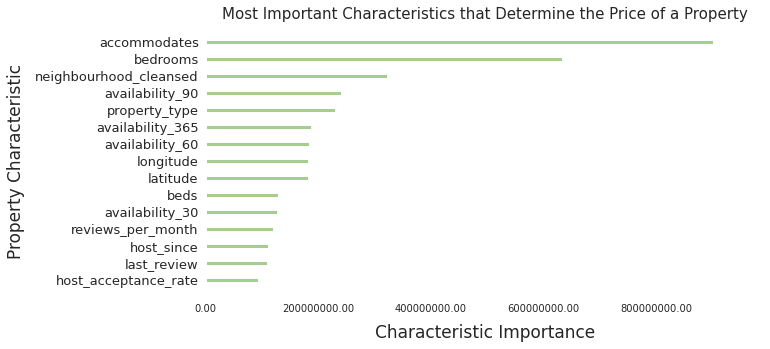

In [26]:
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette("crest", as_cmap=True).colors)

ax = lgb.plot_importance(
    gbm,
    max_num_features=15,
    importance_type='gain',
    figsize=(10,5),

)
ax.set_facecolor("white")

ax.set_xlabel("Characteristic Importance", fontsize=17)
ax.set_ylabel("Property Characteristic", fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=13)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

for txt in ax.texts:
    txt.set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))

plt.title("Most Important Characteristics that Determine the Price of a Property", fontsize=15)
plt.savefig(Path("images") / "lightgbm.png", bbox_inches = "tight")

In [ ]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(
    shap_values,
    X_test,
    max_display=15,
    title="Most Important Characteristics that Determine the Price of a Property"
)